# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools


# keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import HDF5Matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, \
    Dropout, Lambda, Activation, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

Import data as HDF5 Matrix

In [3]:
img_train = HDF5Matrix('/data/joint_scoring/img_train_regression.h5', 'img_train_regression')
img_test = HDF5Matrix('/data/joint_scoring/img_test_regression.h5', 'img_test_regression')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_regression.h5', 'labels_train_regression')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_regression.h5', 'labels_test_regression')

## 2. Model

In [4]:
def conv_model():
    # create model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255., input_shape=(150, 150, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=1024, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=512, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, kernel_initializer="he_normal"))

    # Compile model
    model.compile(optimizer="adam", loss="mean_squared_error",
                  metrics=["mae"])

    return model

In [5]:
# build the model
model = conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
__________

In [6]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [7]:
print(new_folder)

20171105_000953


In [8]:
desc = "Regression model (MSE) on original data"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [9]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [10]:
# Fit the model
model.fit(x=img_train, y=labels_train, batch_size=100, epochs=25, verbose=1,
          callbacks=[tb_callback], validation_data=(img_test, labels_test),
          shuffle="batch")

Train on 72625 samples, validate on 19709 samples
Epoch 1/25
72625/72625 [==============================] - 162s - loss: 151.7460 - mean_absolute_error: 5.9731 - val_loss: 128.5239 - val_mean_absolute_error: 5.1621
Epoch 2/25
72625/72625 [==============================] - 153s - loss: 110.6066 - mean_absolute_error: 5.1439 - val_loss: 209.3119 - val_mean_absolute_error: 10.6351
Epoch 3/25
72625/72625 [==============================] - 148s - loss: 98.3430 - mean_absolute_error: 4.8815 - val_loss: 95.4922 - val_mean_absolute_error: 4.7823
Epoch 4/25
72625/72625 [==============================] - 148s - loss: 88.3411 - mean_absolute_error: 4.6560 - val_loss: 95.2656 - val_mean_absolute_error: 4.5784
Epoch 5/25
72625/72625 [==============================] - 148s - loss: 81.0310 - mean_absolute_error: 4.5202 - val_loss: 108.7411 - val_mean_absolute_error: 5.9525
Epoch 6/25
72625/72625 [==============================] - 149s - loss: 74.4293 - mean_absolute_error: 4.3728 - val_loss: 88.2606 

In [11]:
# Final evaluation of the model
scores = model.evaluate(img_test, labels_test, verbose=0)
print(scores)

[83.538064816050209, 3.897641643226295]


In [12]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [13]:
from sklearn.metrics import classification_report
pred = model.predict(img_test)

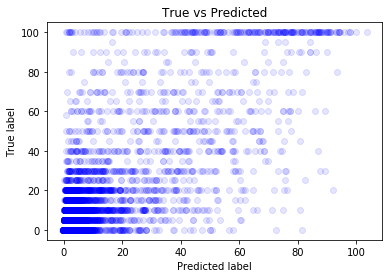

In [14]:
plt.title("True vs Predicted")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.scatter(x=pred, y=labels_test, color="blue", alpha=0.1)

plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [17]:
mean_absolute_error(y_true=labels_test, y_pred=pred)

3.8976416352665089

In [18]:
mean_squared_error(y_true=labels_test, y_pred=pred)

83.538064687958041

In [19]:
r2_score(y_true=labels_test, y_pred=pred)

0.60135111942747499

In [20]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray_regression_original.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)